-> AIM: Create a 3d model of the worm c.elegans from planar images of it
* Histogram equalise images (CLAHE)
* 3d median filter
* 

In [1]:
import cv2
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from PIL import Image
import skimage.io
from scipy.ndimage import median_filter
from scipy import signal
from skimage import exposure

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
images = []
subfolder = 'testimages/2022.12.21_APS018_Infection_PA14-GacA_40X_40 _EM-4_D2_3_7047-1,2022.12.21_APS018_Infection_PA14[...]'
# sub = '2022.12.21_APS018_Infection_PA14-GacA_40X_40 _EM-4_D2_3_7047-'
for i in range(14): # number of tif layers
    address = subfolder + '/' + str(i+1) + '.jpg'
    img = skimage.io.imread(address)
    images.append(img)

In [9]:
# equalised_images = []
# clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(10,10))

# for i in range(len(images)):
#     img = clahe.apply(images[i])
#     equalised_images.append(img)

In [4]:
np_images = np.stack(images, axis=2)

In [9]:
np_equalised_images = exposure.equalize_adapthist(np_images, clip_limit=0.03)
equalised_images = np.split(np_equalised_images, np_equalised_images.shape[2], axis=2)
equalised_images = [np.squeeze(img) for img in equalised_images]

In [10]:
for eqimg in equalised_images:
    cv2.imshow('image', eqimg)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [12]:
# med_blur_images = []
# for i in range(len(equalised_images)):
#     scaled_image = cv2.normalize(equalised_images[i], None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
#     medimg = cv2.medianBlur(scaled_image, 3) # 21
#     med_blur_images.append(medimg)


In [14]:
eq_images = np.stack(equalised_images, axis=2)

In [15]:
eq_images.shape

(512, 512, 14)

In [16]:
med_blur_images_numpyarray = signal.medfilt(eq_images, kernel_size=(3,3,3))
med_blur_images = np.split(med_blur_images_numpyarray, med_blur_images_numpyarray.shape[2], axis=2)
med_blur_images = [np.squeeze(img) for img in med_blur_images]

In [17]:
for med_img in med_blur_images:
    cv2.imshow('image', med_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [21]:
def convert_float64_to_uint8(float64_images):
    uint8_images = []
    for float64_image in float64_images:
        # Normalize pixel values to the range [0, 255]
        norm_image = cv2.normalize(float64_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        # Convert data type to uint8
        uint8_image = norm_image.astype(np.uint8)
        uint8_images.append(uint8_image)
    return uint8_images

uint8_med_blur = convert_float64_to_uint8(med_blur_images)

In [24]:
for med_img in uint8_med_blur:
    cv2.imshow('image', med_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [26]:
binary_images = []
for med_img in uint8_med_blur:
    _, binary_image = cv2.threshold(med_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # binary_image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    # _, binary_image = cv2.threshold(eqimg, 0, 255, cv2.THRESH_BINARY)
    binary_images.append(binary_image)


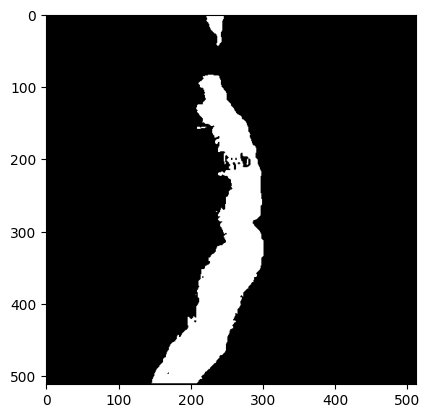

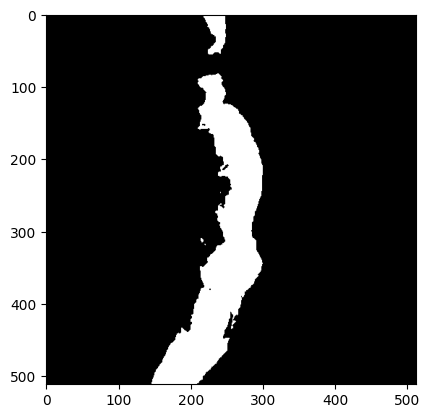

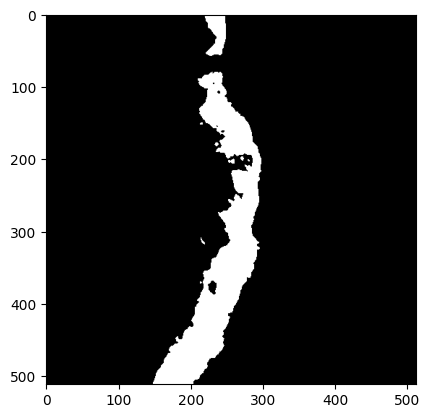

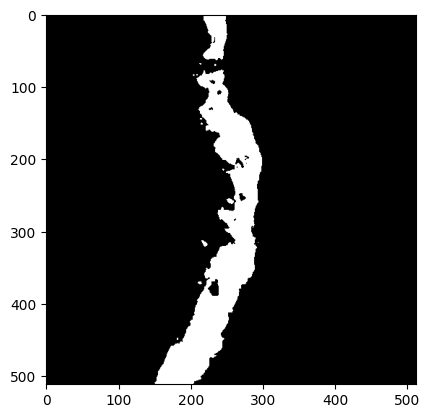

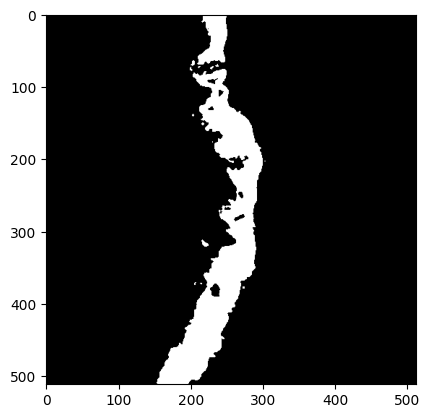

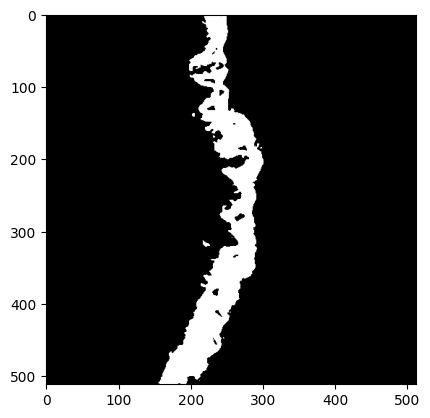

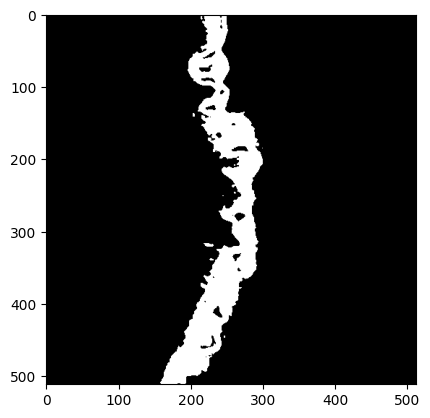

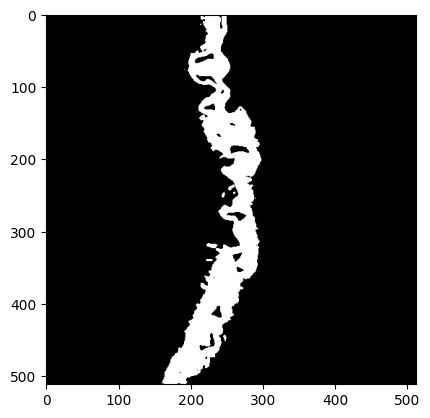

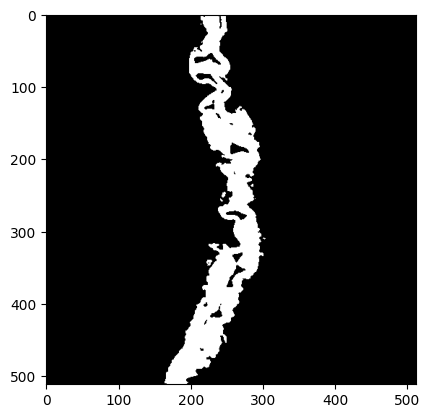

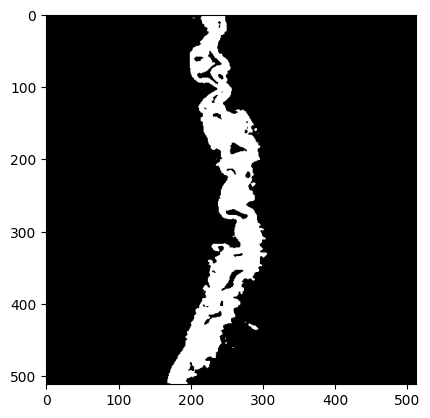

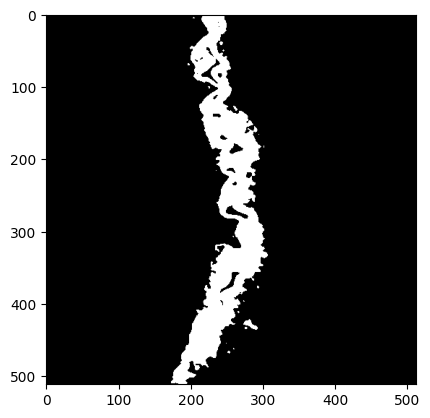

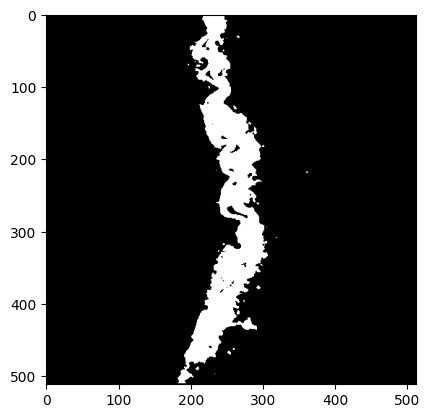

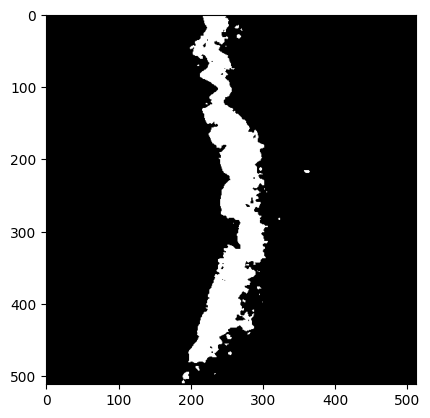

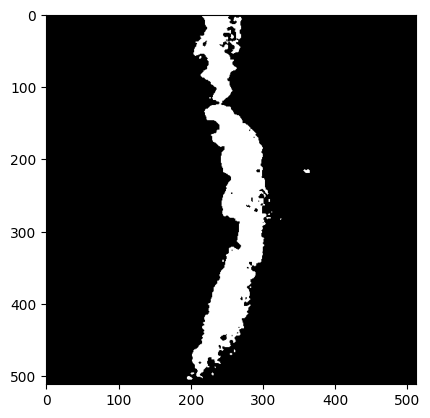

In [27]:
for bin_img in binary_images:
    plt.imshow(bin_img, cmap='gray')
    plt.show()

In [28]:
kernel_size = 5
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))

# Apply morphological closing operation to each binary image
closed_images = []
for binary_image in binary_images:
    closed_img = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel, iterations=1)
    closed_images.append(closed_img)

In [29]:
# Extract pixel coordinates and map them to 3D space
coords = []
for i, image in enumerate(closed_images):
    coords_i = np.column_stack(np.where(image > 0))
    coords_i = np.hstack((coords_i, np.full((coords_i.shape[0], 1), -i)))  # Mapping to Z-coordinate
    coords.append(coords_i)

# Combine the pixel coordinates from all images
all_coords = np.concatenate(coords)

# Scale and normalize the coordinates
scale_factor_z = 3  # Adjust the scale factor for the z-axis as needed
all_coords[:, 2] = all_coords[:, 2] * scale_factor_z

# Calculate the center of the point cloud
center = np.mean(all_coords, axis=0)

# Translate the coordinates to center the point cloud
all_coords[:, 0] = all_coords[:, 0] - center[0]
all_coords[:, 1] = all_coords[:, 1] - center[1]
all_coords[:, 2] = all_coords[:, 2] - center[2]

# Create a point cloud
point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(all_coords[:, [1, 0, 2]])  # Swap X and Y axes for Open3D

In [30]:
# Visualize the point cloud
downpcd = point_cloud.voxel_down_sample(voxel_size=0.01)

o3d.visualization.draw_geometries([point_cloud],
                                  zoom=1,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[0, 0, 0],
                                  up=[-0.0694, -0.9768, 0.2024],
                                  point_show_normal=True,)


In [31]:
print(point_cloud)

PointCloud with 320527 points.


In [32]:
all_coords[:, [2, 1, 0]] = all_coords[:, [1, 0, 2]]  # Swap back X and Y axes
all_coords[:, 0] = all_coords[:, 0] + center[0]
all_coords[:, 1] = all_coords[:, 1] + center[1]
all_coords[:, 2] = all_coords[:, 2] + center[2]

inverse_scale_factor_z = 1 / scale_factor_z
all_coords[:, 2] = all_coords[:, 2] * inverse_scale_factor_z

layer_coords = {}
for coord in all_coords:
    z = coord[2]
    if z not in layer_coords:
        layer_coords[z] = []
    layer_coords[z].append(coord)

reconstructed_images = []
for z, layer in layer_coords.items():
    layer_coords_np = np.array(layer)
    layer_coords_np[:, [0, 1]] = layer_coords_np[:, [1, 0]]  # Swap X and Y axes
    layer_coords_np[:, 0] = layer_coords_np[:, 0] - np.min(layer_coords_np[:, 0])
    layer_coords_np[:, 1] = layer_coords_np[:, 1] - np.min(layer_coords_np[:, 1])
    image_shape = (np.max(layer_coords_np[:, 0]) + 1, np.max(layer_coords_np[:, 1]) + 1)
    binary_image = np.zeros(image_shape, dtype=np.uint8)
    binary_image[layer_coords_np[:, 0], layer_coords_np[:, 1]] = 255
    reconstructed_images.append(binary_image)

# Display the reconstructed images separately
# for i, image in enumerate(reconstructed_images):
#     plt.figure()
#     plt.imshow(image, cmap='gray')
#     plt.axis('off')
#     plt.title(f"Reconstructed Image {i+1}")

#     plt.show()

In [33]:
# # Assume the code to reconstruct the point cloud and generate 'reconstructed_images' is present

# # Apply Convex Hull and display the results on separate images
# for i, image in enumerate(reconstructed_images):
#     # Find contours in the image
#     contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#     # Create a blank image for displaying the convex hulls
#     convex_hull_image = np.zeros_like(image)

#     # Draw convex hulls on the image
#     for contour in contours:
#         hull = cv2.convexHull(contour)
#         cv2.drawContours(convex_hull_image, [hull], 0, 255, 2)

#     # # Display the original reconstructed image and the image with convex hulls side by side
#     # fig, axes = plt.subplots(1, 2, figsize=(8, 4))
#     # axes[0].imshow(image, cmap='gray')
#     # axes[0].axis('off')
#     # axes[0].set_title(f"Reconstructed Image {i+1}")
#     # axes[1].imshow(convex_hull_image, cmap='gray')
#     # axes[1].axis('off')
#     # axes[1].set_title(f"Convex Hulls on Image {i+1}")

#     # plt.tight_layout()
#     # plt.show()


In [34]:
# Assume the code to reconstruct the point cloud and generate 'reconstructed_images' is present

# Convert images with convex hulls back into a point cloud
coords = []
for i, image in enumerate(reconstructed_images):
    # Extract pixel coordinates
    coords_i = np.column_stack(np.where(image > 0))
    coords_i = np.hstack((coords_i, np.full((coords_i.shape[0], 1), -i)))  # Mapping to Z-coordinate
    coords.append(coords_i)

# Combine the pixel coordinates from all images
all_coords = np.concatenate(coords)

# Scale and normalize the coordinates
scale_factor_z = 1  # Adjust the scale factor for the z-axis as needed
all_coords[:, 2] = all_coords[:, 2] * scale_factor_z

# Calculate the center of the point cloud
center = np.mean(all_coords, axis=0)

# Translate the coordinates to center the point cloud
all_coords[:, 0] = all_coords[:, 0] - center[0]
all_coords[:, 1] = all_coords[:, 1] - center[1]
all_coords[:, 2] = all_coords[:, 2] - center[2]

# Create a point cloud
point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(all_coords[:, [1, 0, 2]])  # Swap X and Y axes for Open3D

# Visualize the point cloud
downpcd = point_cloud.voxel_down_sample(voxel_size=0.01)

o3d.visualization.draw_geometries([point_cloud],
                                  zoom=1,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[0, 0, 0],
                                  up=[-0.0694, -0.9768, 0.2024],
                                  point_show_normal=True)

In [ ]:
# # Assume the code to reconstruct the point cloud and generate 'reconstructed_images' is present

# # Detect circles using Hough Circle Transform and display them on separate images
# for i, image in enumerate(reconstructed_images):
#     # Apply Gaussian blur to reduce noise (adjust parameters as needed)
#     blurred_image = cv2.GaussianBlur(image, (5, 5), 0)

#     # Apply Hough Circle Transform (adjust parameters as needed)
#     circles = cv2.HoughCircles(blurred_image, cv2.HOUGH_GRADIENT, dp=1, minDist=30,
#                                param1=50, param2=30, minRadius=5, maxRadius=20)

#     # Create a blank image for displaying the circles
#     circle_image = np.zeros_like(image)

#     # Draw detected circles on the circle image
#     if circles is not None:
#         circles = np.uint16(np.around(circles))
#         for circle in circles[0, :]:
#             center = (circle[0], circle[1])
#             radius = circle[2]
#             cv2.circle(circle_image, center, radius, 255, 2)

#     # Display the original reconstructed image and the circle image side by side
#     fig, axes = plt.subplots(1, 2, figsize=(8, 4))
#     axes[0].imshow(image, cmap='gray')
#     axes[0].axis('off')
#     axes[0].set_title(f"Reconstructed Image {i+1}")
#     axes[1].imshow(circle_image, cmap='gray')
#     axes[1].axis('off')
#     axes[1].set_title(f"Hough Circles on Image {i+1}")

#     plt.tight_layout()
#     plt.show()
